In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой мы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведим общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируем по убыванию общего количества просмотров.

In [6]:

query = '''
SELECT DISTINCT(DATE_TRUNC('month',creation_date)) AS month_date,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month',creation_date)) AS total_views
FROM stackoverflow.posts     
WHERE creation_date::date BETWEEN '2008-01-01' AND '2008-12-31'
ORDER BY total_views DESC
'''


sample_df = pd.read_sql_query(query, con=engine) 

In [7]:
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Да, данные отличаются,возможно это связано с началом учебного года

# Задание 2

Выведем имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведем количество уникальных значений `user_id`. Отсортируем результат по полю с именами в лексикографическом порядке.

In [9]:

query = '''
SELECT u.display_name,
       COUNT(DISTINCT(p.user_id))
FROM stackoverflow.posts AS p
INNER JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
INNER JOIN stackoverflow.users AS u ON p.user_id = u.id
WHERE pt.type = 'Answer'
AND p.creation_date::date BETWEEN u.creation_date::date AND u.creation_date::date + INTERVAL'1 month'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name

'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Наблюдаются  значения отличные от единицы у поля count некоторых пользователей. Полагаю, это свидетильствует о том, что они
отвечали нескольким пользователям  


# Задание 3

Выведем количество постов за 2008 год по месяцам. Отберем посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируем таблицу по значению месяца по убыванию.

In [11]:

query = '''
WITH u AS
(SELECT users.id
 FROM stackoverflow.users
 INNER JOIN stackoverflow.posts AS p ON users.id = p.user_id
 WHERE (users.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30')
 AND (p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31' )
)
SELECT DISTINCT(DATE_TRUNC('month', p.creation_date)) AS month,
       COUNT(DISTINCT p.id) 
FROM u
INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id
GROUP BY DATE_TRUNC('month', p.creation_date)
ORDER BY month DESC
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


В Августе, есть посты от пользователей, которые зарегестрировались в сентябре, возможно это посты с ответами на вопросы, которые были созданы до сентября

# Задание 4

Используя данные о постах, выведем несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [13]:

query = '''
SELECT p.user_id,
       p.creation_date,
       p.views_count,
       SUM(p.views_count) OVER (PARTITION BY p.user_id ORDER BY p.creation_date) AS cumulative_count
FROM stackoverflow.posts AS p
ORDER BY p.user_id, p.creation_date
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдем среднее количество постов пользователей в день за август 2008 года. Отберем данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитываем. 

Отсортируем результат по возрастанию среднего количества постов. Значения можно не округлять.

In [14]:

query = '''
WITH u AS (
SELECT DISTINCT(posts.id),
       posts.user_id,
       posts.creation_date::date,
       COUNT(posts.id) OVER(PARTITION BY user_id, creation_date::date) AS per_day,
       COUNT(posts.id) OVER(PARTITION BY user_id) AS summary
FROM stackoverflow.posts
WHERE posts.creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
)
SELECT user_id,
      CAST(COUNT(DISTINCT id) AS float)/CAST(COUNT(DISTINCT creation_date) AS float) AS avg_daily     
FROM u
WHERE summary > 120
GROUP BY user_id
ORDER BY avg_daily
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберем дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудем округлить результат. 

In [15]:

query = '''
WITH u AS
(SELECT users.id,
        COUNT(DISTINCT p.creation_date::date)
FROM stackoverflow.users
INNER JOIN stackoverflow.posts AS p ON users.id = p.user_id
WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-7'
GROUP BY users.id
)
SELECT CAST(ROUND(AVG(count)) AS int) 
FROM u

'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,round
0,2


# Задание 7

Выведем историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируем вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавим в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажем `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` нам не нужно.

Посмотрим внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [17]:

query = '''
WITH u AS(
    SELECT p.user_id,
       p.creation_date,
       EXTRACT(MONTH FROM LAG(p.creation_date, 2, NULL) OVER(PARTITION BY p.user_id ORDER BY p.creation_date)) AS second_last_month       
FROM stackoverflow.posts AS p       
)
SELECT u.user_id,
       u.creation_date,
       CASE(second_last_month)
       WHEN 1 THEN 'January'
       WHEN 2 THEN 'February'
       WHEN 3 THEN 'March'
       WHEN 4 THEN 'April'
       WHEN 5 THEN 'May'
       WHEN 6 THEN 'June'
       WHEN 7 THEN 'July'
       WHEN 8 THEN 'August'
       WHEN 9 THEN 'September'
       WHEN 10 THEN 'October'
       WHEN 11 THEN 'November'
       WHEN 12 THEN 'December'
       END
FROM u
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитаем аналог Retention Rate по месяцам для пользователей StackOverflow. Объединим пользователей в когорты по месяцу их первого поста. Возвращение определяем по наличию поста в текущем месяце. 

In [18]:

query = '''
WITH u AS
(SELECT DISTINCT user_id,
        FIRST_value(DATE_TRUNC('month',creation_date)) OVER(PARTITION BY user_id ORDER BY creation_date) AS dt
FROM stackoverflow.posts
)
,profile AS
(SELECT user_id AS id,
        dt,
        COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
FROM u
),
sessions AS 
(SELECT user_id,
        DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile AS p
JOIN sessions s ON p.id = s.user_id
GROUP BY 1,
         2,
         4    
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Построим тепловую карту Retention Rate.

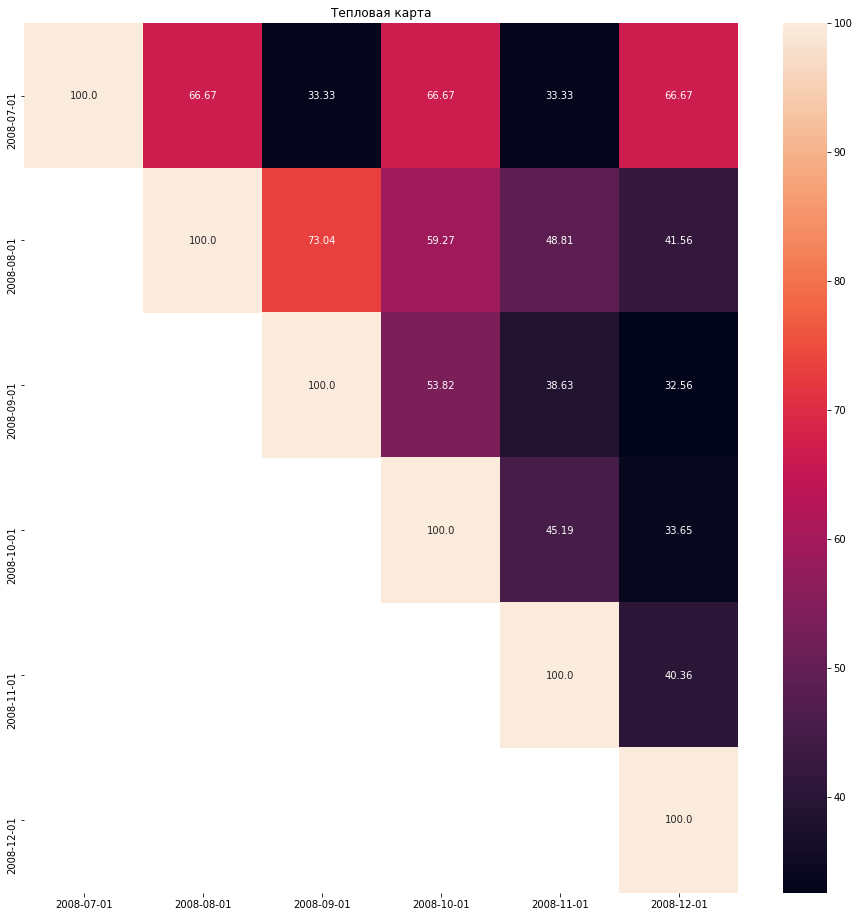

In [19]:
# постройте тепловую карту Retention Rate
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Если обратить внимание на июльскую когорту, то можем заметить, что retention rate чередует 2 значения, каждый месяц, кроме того, мы ввидим, что количество пользователей в июле составляет не более 3 человек, из чего можем сделать ввыоды, что это скорее сего создатели сайта, т.к. Stackovereflow начал работать в 2008 году в августе

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразим таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлим значение процента до двух знаков после запятой.


In [21]:

query = '''
WITH P AS(SELECT DISTINCT(EXTRACT(MONTH FROM creation_date::date)) AS date,
       COUNT(id) OVER(PARTITION BY DATE_TRUNC('month', creation_date)) AS posts_count
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31')
SELECT date,
       posts_count,
       ROUND((CAST((posts_count * 100) AS numeric)/(LAG(posts_count) OVER (ORDER BY date)) - 100), 2) AS percentage
FROM p
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,date,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Text(0.5, 1.0, 'Количество постов по месяцам')

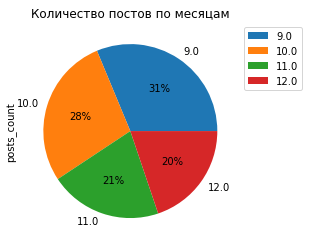

In [22]:

ax = sample_df.groupby(['date']). sum ().plot(kind='pie', y='posts_count',autopct='%1.0f%%')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_title('Количество постов по месяцам')

# Задание 10

Выгрузим данные активности пользователя, который опубликовал больше всего постов за всё время. Выведим данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [23]:

query = '''
WITH u AS 
(SELECT DISTINCT user_id,
        COUNT(id) OVER (PARTITION BY user_id)
 FROM stackoverflow.posts
 ORDER BY count DESC
 LIMIT(1)
),
week AS
(SELECT EXTRACT(WEEK FROM creation_date) AS week_creation,
        creation_date
 FROM stackoverflow.posts AS p
 INNER JOIN u ON u.user_id = p.user_id
 WHERE creation_date::date BETWEEN '2008-10-01' AND '2008-10-31'
)
SELECT DISTINCT week_creation,
       LAST_VALUE(creation_date) OVER (ORDER BY week_creation)
FROM week
ORDER BY week_creation
'''


sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,week_creation,last_value
0,40.0,2008-10-05 08:16:26
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 20:51:12
4,44.0,2008-10-31 21:54:56
